## Accessing NOAA's Sea Surface Temperature - Wood Hole Oceanographic Institution (WHOI) Climate Data Record (CDR) with the Planetary Computer STAC API

The Sea Surface Temperature-Woods Hole Oceanographic Institution (WHOI) Climate Data Record (CDR) is one of three CDRs which combine to form the NOAA Ocean Surface Bundle (OSB) CDR. The resultant sea surface temperature (SST) data are produced through modeling the diurnal variability in combination with AVHRR SST observations. The final record is output to a 3-hourly 0.25° resolution grid over the global ice-free oceans from January 1988—present.


### Data access

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key. The [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) sets the environment variable "PC_SDK_SUBSCRIPTION_KEY" when your server is started. When your Planetary Computer [account request](https://planetarycomputer.microsoft.com/account/request) was approved, a pair of subscription keys were automatically generated for you. You can view your keys by singing in to the [developer portal](https://planetarycomputer.developer.azure-api.net/). The API key may be set manually via the following code:

```python
pc.settings.set_subscription_key(<YOUR API Key>)
```

The datasets hosted by the Planetary Computer are available from [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/). We'll use [pystac-client](https://pystac-client.readthedocs.io/) to search the Planetary Computer's [STAC API](https://planetarycomputer.microsoft.com/api/stac/v1/docs) for the subset of the data that we care about, and then we'll load the data directly from Azure Blob Storage. We'll specify a `modifier` so that we can access the data stored in the Planetary Computer's private Blob Storage Containers. See [Reading from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) and [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/) for more. 

First, let's fetch all items from the first day of 1988.

In [5]:
import planetary_computer
import pystac_client

client = pystac_client.Client.open(
    "https://pct-apis-staging.westeurope.cloudapp.azure.com/stac",
    modifier=planetary_computer.sign_inplace,
)
item_search = client.search(
    collections="noaa-cdr-sea-surface-temperature-whoi",
    datetime="1988-01-01",
)
items = list(item_search.items())
print(items)

[<Item id=SEAFLUX-OSB-CDR_V02R00_SST_D19880101_C20160820-7>, <Item id=SEAFLUX-OSB-CDR_V02R00_SST_D19880101_C20160820-6>, <Item id=SEAFLUX-OSB-CDR_V02R00_SST_D19880101_C20160820-5>, <Item id=SEAFLUX-OSB-CDR_V02R00_SST_D19880101_C20160820-4>, <Item id=SEAFLUX-OSB-CDR_V02R00_SST_D19880101_C20160820-3>, <Item id=SEAFLUX-OSB-CDR_V02R00_SST_D19880101_C20160820-2>, <Item id=SEAFLUX-OSB-CDR_V02R00_SST_D19880101_C20160820-1>, <Item id=SEAFLUX-OSB-CDR_V02R00_SST_D19880101_C20160820-0>]


### Assets

Each item has a Cloud Optimized GeoTIFF (COG) asset containing the sea surface temperature in degrees Celsius.

In [6]:
from rich.table import Table

item = items[0]
table = Table("Key", "Title")
for key, asset in item.assets.items():
    table.add_row(key, asset.title)
table

┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key                     ┃ Title                               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ fill_missing_qc         │ Quality flag for missing data       │
│ sea_surface_temperature │ NOAA CDR of sea surface temperature │
│ tilejson                │ TileJSON with default rendering     │
│ rendered_preview        │ Rendered preview                    │
└─────────────────────────┴─────────────────────────────────────┘

### Load data

Let's load all the data into an xarray using [odc-stac](https://github.com/opendatacube/odc-stac).

In [7]:
import odc.stac

data = odc.stac.load(items, bands="sea_surface_temperature")
data

<xarray.Dataset>
Dimensions:                  (latitude: 720, longitude: 1440, time: 8)
Coordinates:
  * latitude                 (latitude) float64 89.88 89.62 ... -89.62 -89.88
  * longitude                (longitude) float64 -179.9 -179.6 ... 179.6 179.9
    spatial_ref              int32 4326
  * time                     (time) datetime64[ns] 1988-01-01 ... 1988-01-01T...
Data variables:
    sea_surface_temperature  (time, latitude, longitude) float32 nan nan ... nan

### Visualize

Now, let's visualize one three-hour window.

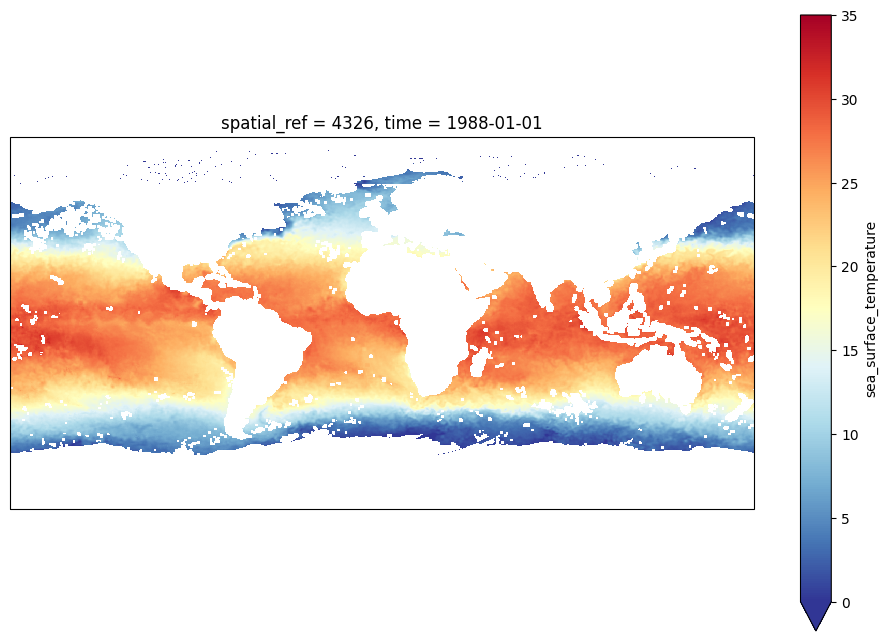

In [8]:
from cartopy import crs
from matplotlib import pyplot

figure = pyplot.figure(figsize=(12, 8))
axes = pyplot.axes(projection=crs.Mercator())
data["sea_surface_temperature"][0].plot.imshow(cmap="RdYlBu_r", vmin=0, vmax=35)